## Hughes Net Report

The goal of this notebook is to generate all visualizations for Hughes Net offers.

In [3]:
import os
import pandas as pd
from aggregators import (
    race, 
    income, 
    redlining, 
    plot_race, 
    speed_breakdown, 
    bucket_and_bin
)

In [4]:
# inputs
fn_hughes = "../data/output/speed_price_hughes.csv.gz"
fn_all_hughes = "../data/open_address/processed/csv/city_of_boston-addresses-city.csv.gz"

# outputs
fn_speed = "../data/output/figs/fig1_hughes.csv"
fn_fig3a = "../data/output/figs/fig3_income.csv"
fn_fig3b = "../data/output/figs/fig3_race.csv"
fn_fig3c = "../data/output/figs/fig3_redline.csv"

# notebook variable
ISP = 'Hughes Net'

In [5]:
hughes = pd.read_csv(fn_hughes, compression='gzip')
len(hughes)

700

In [6]:
all_hughes = pd.read_csv(fn_all_hughes, compression='gzip')
len(all_hughes)

700

In [7]:
hughes.head()

,address_full,incorporated_place,major_city,state,lat,lon,block_group,collection_datetime,provider,speed_down,...,fastest_speed_price,fn,redlining_grade,race_perc_non_white,income_lmi,ppl_per_sq_mile,n_providers,income_dollars_below_median,internet_perc_broadband,median_household_income
0,"451, Walnut Avenue, Boston, MA, 02130",Boston,Boston,MA,42.311890,-71.097720,2,1.701823e+09,hughes,15,...,149.99,../data/intermediary/isp/hughes\boston\111.geo...,C,0.729963,0.823600,9957.395607,2.0,13459.0,0.772834,62839.0
1,"18, Landing Street, Boston, MA, 02128",Boston,Boston,MA,42.371177,-71.042193,2,1.701823e+09,hughes,15,...,149.99,../data/intermediary/isp/hughes\boston\117.geo...,D,0.676556,0.206519,16437.348598,3.0,60541.0,0.654008,15757.0
2,"151, Manthorne Road, Boston, MA, 02132",Boston,Boston,MA,42.292220,-71.153400,2,1.701823e+09,hughes,15,...,149.99,../data/intermediary/isp/hughes\boston\118.geo...,B,0.142339,1.428845,6896.379245,3.0,-32720.0,0.868613,109018.0
3,"1330, Commonwealth Avenue, Boston, MA, 02134",Boston,Boston,MA,42.347910,-71.134990,2,1.701823e+09,hughes,15,...,149.99,../data/intermediary/isp/hughes\boston\119.geo...,C,0.496799,0.791305,18394.215596,3.0,15923.0,0.978308,60375.0
4,"30, Sheridan Street, Boston, MA, 02130",Boston,Boston,MA,42.321510,-71.108200,1,1.701822e+09,hughes,15,...,149.99,../data/intermediary/isp/hughes\boston\12.geoj...,C,0.427459,1.574602,11078.031627,2.0,-43841.0,0.994695,120139.0


In [8]:
print('Percent of households not served: ', str(round(len(hughes)/len(all_hughes)*100, 2))+'%')

Percent of households not served:  100.0%


In [9]:
hughes = hughes[hughes.speed_down != 0]
len(hughes)

700

In [10]:
hughes = bucket_and_bin(hughes)
hughes.head()

,address_full,incorporated_place,major_city,state,lat,lon,block_group,collection_datetime,provider,speed_down,...,income_lmi,ppl_per_sq_mile,n_providers,income_dollars_below_median,internet_perc_broadband,median_household_income,income_level,speed_down_bins,race_quantile,is_slow
0,"451, Walnut Avenue, Boston, MA, 02130",Boston,Boston,MA,42.311890,-71.097720,2,1.701823e+09,hughes,15,...,0.823600,9957.395607,2.0,13459.0,0.772834,62839.0,Middle,Slow (<25 Mbps),least white,1
1,"18, Landing Street, Boston, MA, 02128",Boston,Boston,MA,42.371177,-71.042193,2,1.701823e+09,hughes,15,...,0.206519,16437.348598,3.0,60541.0,0.654008,15757.0,Low,Slow (<25 Mbps),least white,1
2,"151, Manthorne Road, Boston, MA, 02132",Boston,Boston,MA,42.292220,-71.153400,2,1.701823e+09,hughes,15,...,1.428845,6896.379245,3.0,-32720.0,0.868613,109018.0,Upper Income,Slow (<25 Mbps),most white,1
3,"1330, Commonwealth Avenue, Boston, MA, 02134",Boston,Boston,MA,42.347910,-71.134990,2,1.701823e+09,hughes,15,...,0.791305,18394.215596,3.0,15923.0,0.978308,60375.0,Middle,Slow (<25 Mbps),integrated,1
4,"30, Sheridan Street, Boston, MA, 02130",Boston,Boston,MA,42.321510,-71.108200,1,1.701822e+09,hughes,15,...,1.574602,11078.031627,2.0,-43841.0,0.994695,120139.0,Upper Income,Slow (<25 Mbps),integrated,1


In [11]:
# who gets options?
hughes[
    (hughes["speed_down"] != hughes["fastest_speed_down"])
    & (~hughes["fastest_speed_down"].isnull())
]["speed_down"].value_counts(normalize=True)

speed_down
15    1.0
Name: proportion, dtype: float64

In [12]:
# make the above for each city:
city2speeds = pd.DataFrame()
for (city, state), _df in hughes.groupby(["major_city", "state"]):
    row = _df.speed_down_bins.value_counts(normalize=True, sort=False).to_frame().T
    row.reset_index(drop=True, inplace=True)
    row["major_city"] = city.title()
    row["state"] = state
    city2speeds = pd.concat([city2speeds, row])
city2speeds.to_csv(fn_speed, index=False)

city2speeds

speed_down_bins,No service,Slow (<25 Mbps),Medium (25-99),Fast (100-199),Blazing (≥200),major_city,state
0,0.0,1.0,0.0,0.0,0.0,Boston,MA


In [13]:
variety = hughes.groupby(['major_city', 'state']).speed_down_bins.value_counts(normalize=True)
homogenous_cities = variety[variety >= .95].index.get_level_values(0)
len(homogenous_cities)

1

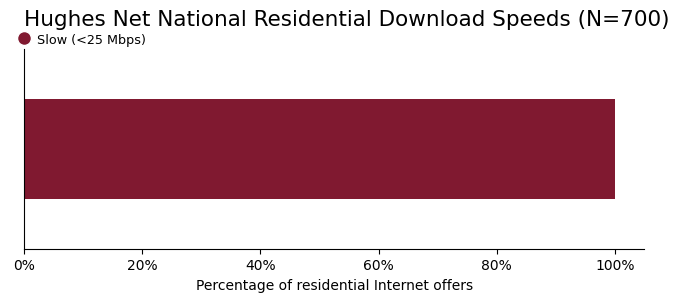

In [14]:
speed_breakdown(hughes, isp=ISP)

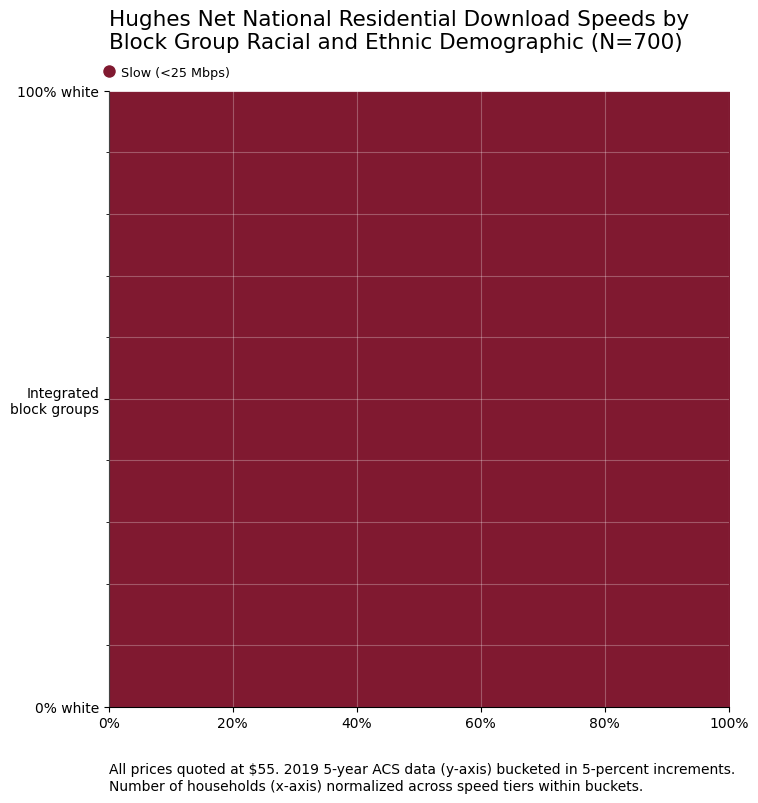

In [15]:
plot_race(hughes, ISP)

/Users/abbycarr/Desktop/CS4973/investigate_NE_isp/notebooks/aggregators.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("race_quantile")


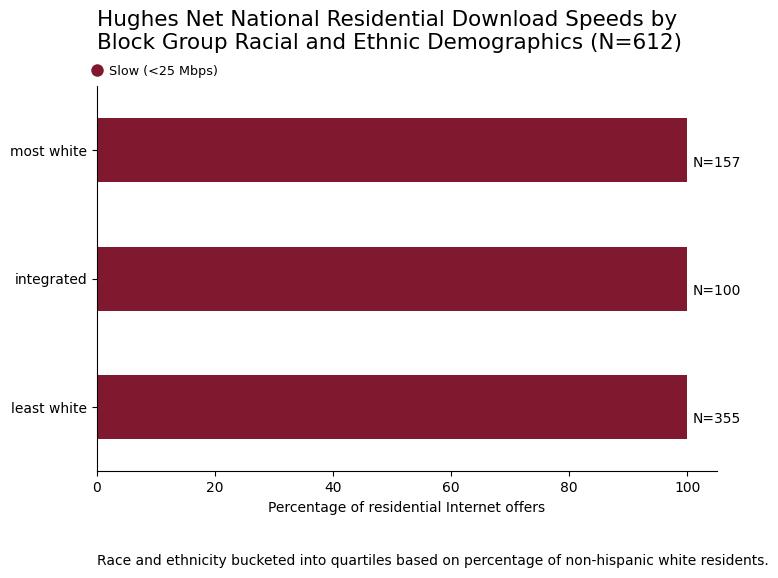

In [16]:
race(hughes, ISP)

/Users/abbycarr/Desktop/CS4973/investigate_NE_isp/notebooks/aggregators.py:239: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("income_level")


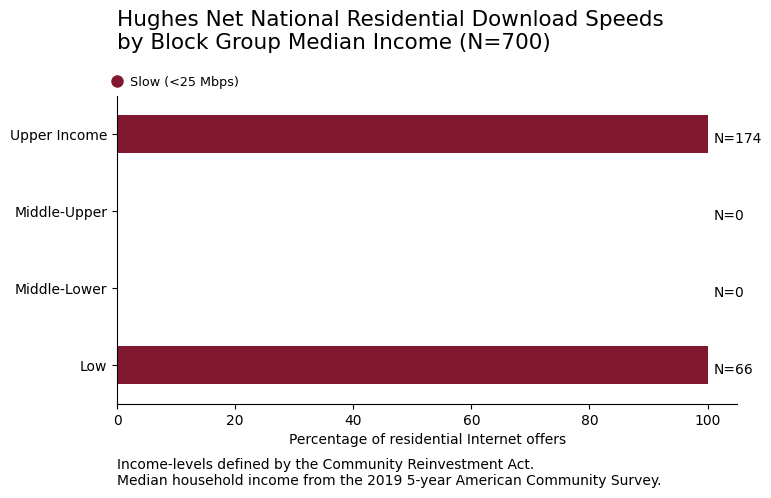

In [17]:
income(hughes, ISP)

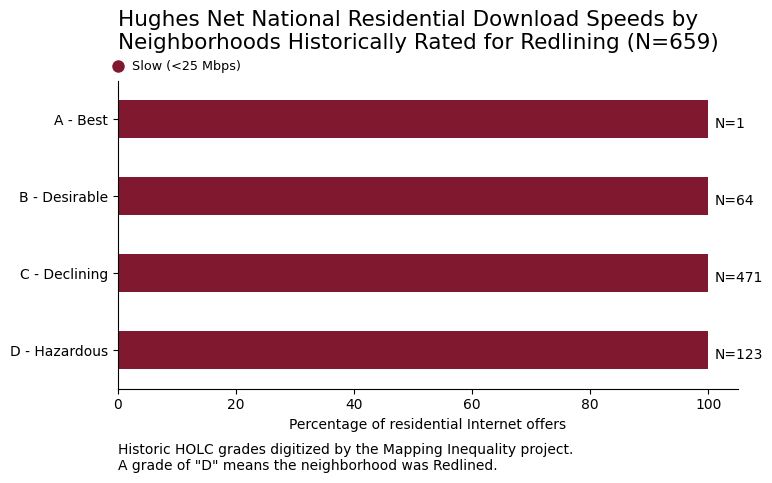

In [18]:
redlining(hughes, ISP)

## City by City

Boston


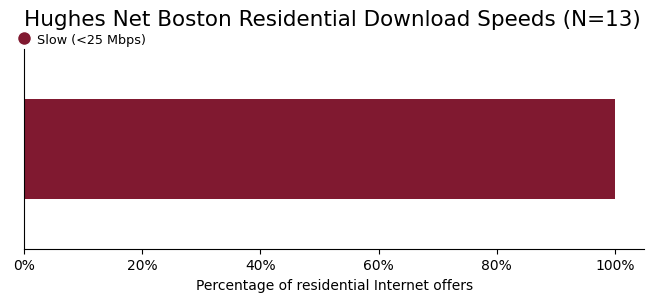

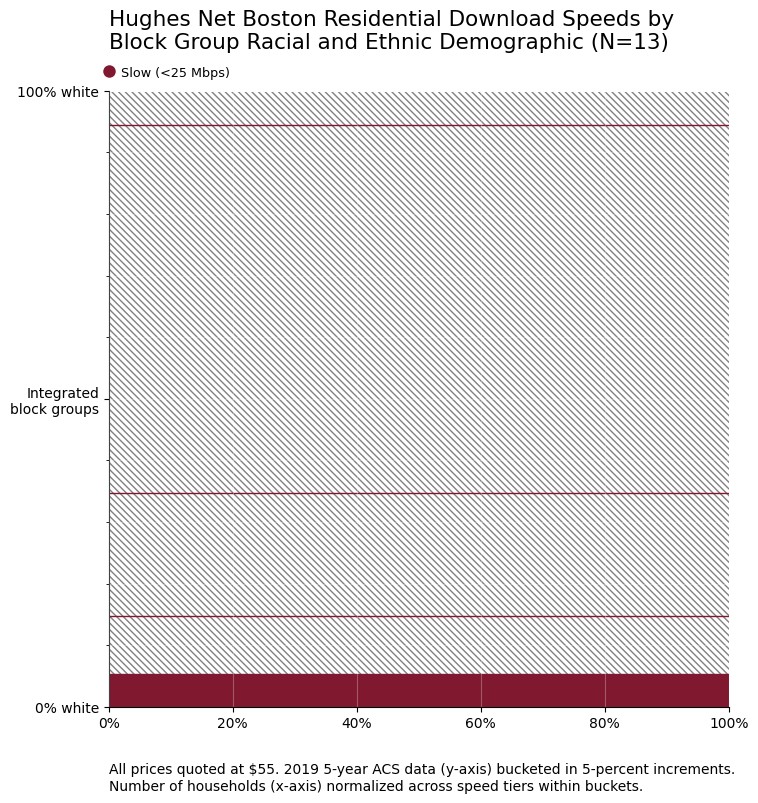

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:197: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("race_quantile")


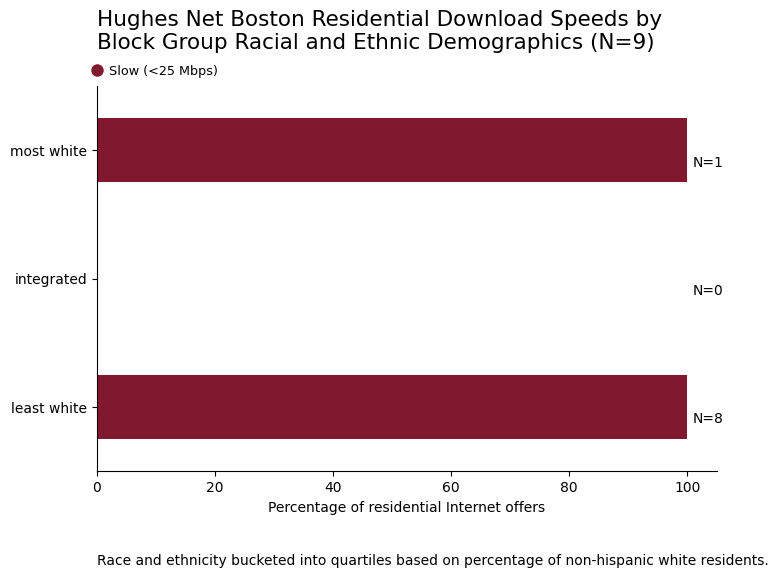

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("income_level")


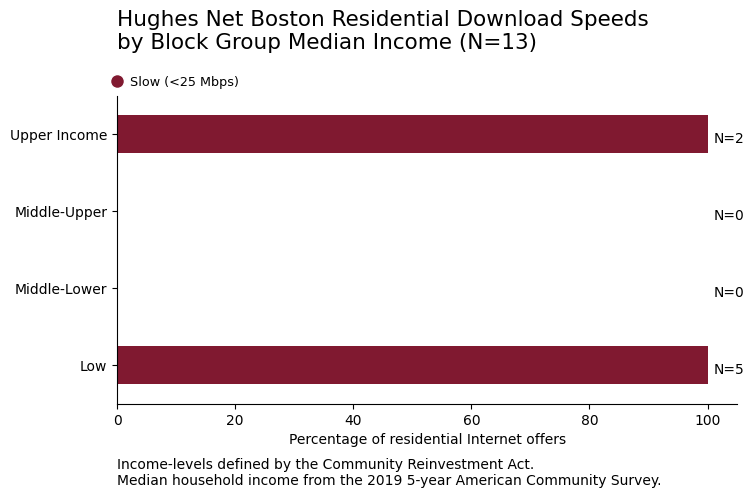

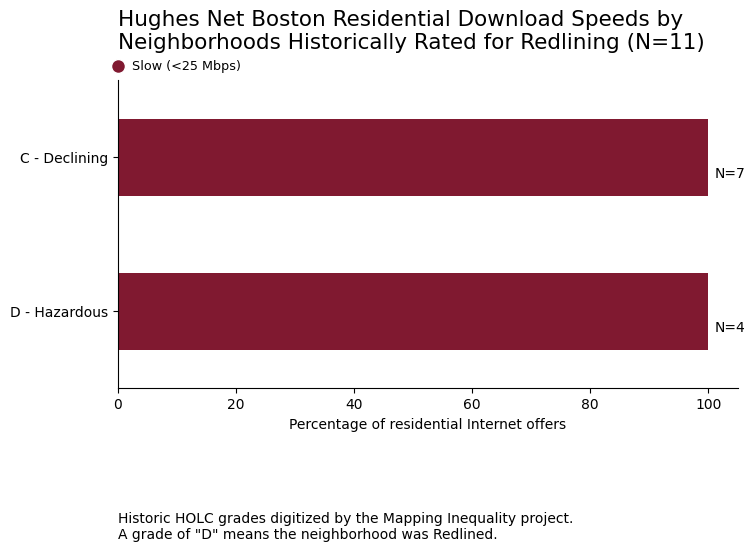

*******************************************************************************


In [17]:
for city, _df in hughes.groupby("major_city"):
    print(city)
    _df = bucket_and_bin(_df, ISP)
    speed_breakdown(_df, ISP, location=city.title())
    plot_race(_df, ISP, location=city.title())
    race(_df, ISP, location=city.title())
    income(_df, ISP, location=city.title())
    redlining(_df, ISP, location=city.title())
    fn_out = f"../data/output/maps/hughes/{city}_offers.csv"
    if not os.path.exists(fn_out):
        os.makedirs(os.path.dirname(fn_out), exist_ok=True)
        _df.to_csv(fn_out, index=False)
    print("*" * 79)

## One city's graphs as an example

In [18]:
from pandas.api.types import CategoricalDtype
from config import income_labels

In [19]:
# outputs
fn_fig3a = '../data/output/figs/fig3_income.csv'
fn_fig3b = '../data/output/figs/fig3_race.csv'
fn_fig3c = '../data/output/figs/fig3_redline.csv'

In [20]:
df_city = bucket_and_bin(hughes[hughes.major_city == "Boston"])

In [21]:
df_city.loc[:, 'income_level'] = df_city['income_level'].astype(
     CategoricalDtype(income_labels, ordered=True)
).copy(deep=True)

to_plot = (df_city.groupby('income_level').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3a)

C:\Users\J-Dog\AppData\Local\Temp\ipykernel_2180\1768510908.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('income_level').speed_down_bins


In [22]:
to_plot = (df_city.groupby('race_quantile').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3b)

C:\Users\J-Dog\AppData\Local\Temp\ipykernel_2180\546127959.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('race_quantile').speed_down_bins


In [23]:
to_plot = (df_city.groupby('redlining_grade').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3c)

In [26]:
# outputs
fn_fig_story_a = '../data/output/figs/story_income_{city}.csv'
fn_fig_story_b = '../data/output/figs/story_race_{city}.csv'
fn_fig_story_c = '../data/output/figs/story_redline_{city}.csv'

In [27]:
for city in ['Boston']:
    df_city = bucket_and_bin(hughes[hughes.major_city == city])
    df_city.loc[:, 'income_level'] = df_city['income_level'].astype(
         CategoricalDtype(income_labels, ordered=True)
    ).copy(deep=True)

    to_plot = (df_city.groupby('income_level').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_a.format(city=city.replace(' ', '_')))
    to_plot = (df_city.groupby('race_quantile').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_b.format(city=city.replace(' ', '_')))
    to_plot = (df_city.groupby('redlining_grade').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_c.format(city=city.replace(' ', '_')))

C:\Users\J-Dog\AppData\Local\Temp\ipykernel_2180\2587229666.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('income_level').speed_down_bins
C:\Users\J-Dog\AppData\Local\Temp\ipykernel_2180\2587229666.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('race_quantile').speed_down_bins


In [28]:
# how many addresses got 6 Mbps or less
len(hughes[hughes.speed_down <= 6])

0

In [29]:
# how many cities got 6 Mbps or less
hughes[hughes.speed_down <= 6].major_city.nunique()

0